In [7]:
its_jupyter_notebook = True

In [8]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
from tqdm.notebook import tqdm
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


sys.path.insert(0, '..')

import dataset.preprocessing as utils
from config import *

In [9]:
emb_dir = os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings')
all_files_name = os.listdir(os.path.join(emb_dir, '32'))
all_files = list(pd.Series(all_files_name).str.extractall('(.*)\.npy').reset_index()[0])

In [10]:
df = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

In [11]:
df_posneg = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_posneg.csv'))

In [12]:
df = df[df.id_query.isin(all_files)].reset_index(drop = True)
df_posneg = df_posneg[df_posneg.id_query.isin(all_files)].reset_index(drop = True)

In [13]:
def load_features(arrays_to_load):
    # Initialize an empty list to store the loaded arrays
    loaded_arrays = []

    # Loop through each file and load the numpy array
    for file_name in tqdm(arrays_to_load):
        # Load the numpy array from file
        array_data = np.load(os.path.join(emb_dir, '32', file_name + '.npy'))

        # Append the loaded array to the list
        loaded_arrays.append(array_data)

    # Stack the loaded arrays along the first axis to create a single array
    result_array = np.stack(loaded_arrays)

    # Verify the shape of the resulting array
    print("Shape of the resulting array:", result_array.shape)
    
    return result_array

In [14]:
posneg_features = load_features(list(df_posneg.id_query))

df_features = load_features(list(df.id_query))

  0%|          | 0/22622 [00:00<?, ?it/s]

Shape of the resulting array: (22622, 2560)


  0%|          | 0/119004 [00:00<?, ?it/s]

Shape of the resulting array: (119004, 2560)


# PCA

In [15]:
scaler = StandardScaler()
pca = PCA(n_components=2)

In [16]:
def create_pca(features):
    numerical_features_scaled = scaler.fit_transform(features)
    pca_result = pca.fit_transform(numerical_features_scaled)
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    return pca_df, pca

In [17]:
pca_df_posneg, pca_posneg = create_pca(posneg_features)

final_df_posneg = pd.concat([pca_df_posneg, df_posneg], axis=1) 

In [18]:
pca_df_features, pca_features = create_pca(df_features)

repeats_df = pd.concat([pca_df_features, df], axis = 1)

### Results positive / negative

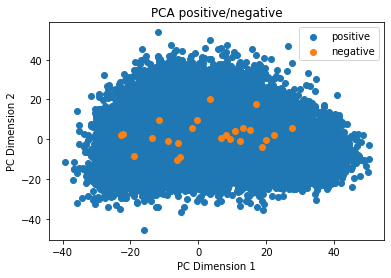

In [19]:
pos_df = final_df_posneg[final_df_posneg.how == 'positive']
neg_df = final_df_posneg[final_df_posneg.how == 'negative']

plt.scatter(pos_df[f'PC1'], pos_df[f'PC2'], label='positive')
plt.scatter(neg_df[f'PC1'], neg_df[f'PC2'], label='negative')

plt.title('PCA positive/negative')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

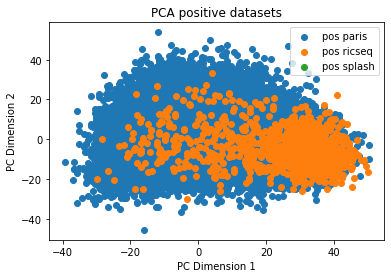

In [20]:
plt.scatter(pos_df[pos_df.dataset == 'paris'][f'PC1'], pos_df[pos_df.dataset == 'paris'][f'PC2'], label='pos paris')
plt.scatter(pos_df[pos_df.dataset == 'ricseq'][f'PC1'], pos_df[pos_df.dataset == 'ricseq'][f'PC2'], label='pos ricseq')
plt.scatter(pos_df[pos_df.dataset == 'splash'][f'PC1'], pos_df[pos_df.dataset == 'splash'][f'PC2'], label='pos splash')


plt.title('PCA positive datasets')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

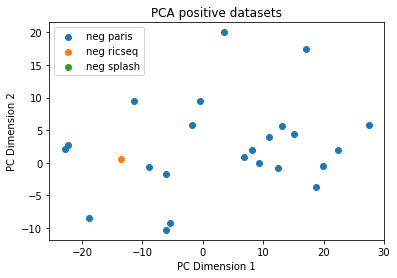

In [21]:
plt.scatter(neg_df[neg_df.dataset == 'paris'][f'PC1'], neg_df[neg_df.dataset == 'paris'][f'PC2'], label='neg paris')
plt.scatter(neg_df[neg_df.dataset == 'ricseq'][f'PC1'], neg_df[neg_df.dataset == 'ricseq'][f'PC2'], label='neg ricseq')
plt.scatter(neg_df[neg_df.dataset == 'splash'][f'PC1'], neg_df[neg_df.dataset == 'splash'][f'PC2'], label='neg splash')


plt.title('PCA positive datasets')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

### Results repeats

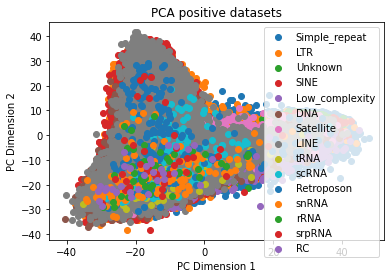

In [22]:
for f in list(repeats_df.feature.unique()):
    plt.scatter(repeats_df[repeats_df.feature == f][f'PC1'], repeats_df[repeats_df.feature == f][f'PC2'], label=f)

plt.title('PCA positive datasets')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

In [40]:
df_groupby = df.groupby(['gene_id', 'feature']).mean().reset_index()[['gene_id', 'feature', 'interacting', 'len_feature', 'length']]

In [41]:
df_groupby['prob_to_sample_f'] = df_groupby['len_feature']/df_groupby['length'] *100

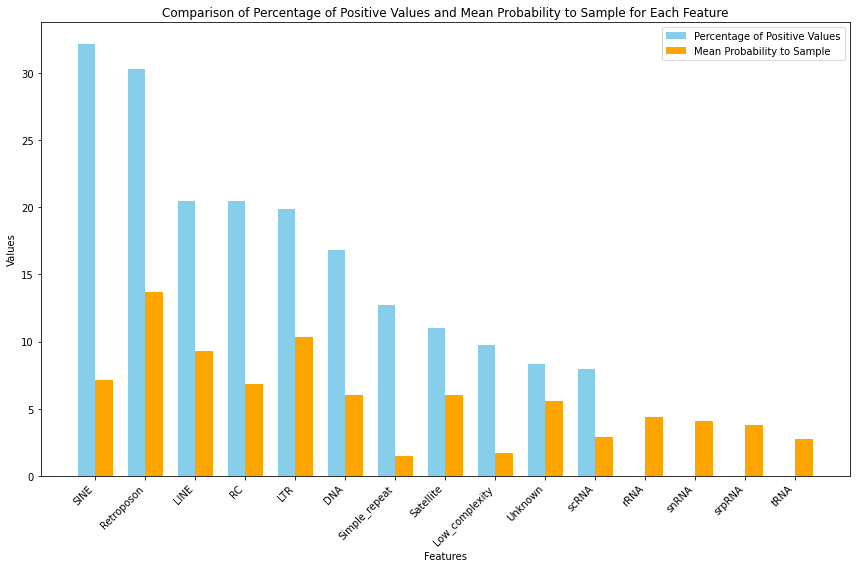

In [42]:
perc_positives = []
features = []
mean_prob_to_sample_f = []

# Iterate through unique features
for f in list(df_groupby.feature.unique()):
    features.append(f)
    df_feature = df_groupby[df_groupby.feature == f]
    p_pos = df_feature.interacting.sum()/df_feature.shape[0] * 100
    perc_positives.append(p_pos)
    mean_prob_to_sample_f.append(df_feature.prob_to_sample_f.mean())

sorted_data = sorted(zip(perc_positives, mean_prob_to_sample_f, features), reverse=True)
perc_positives, mean_prob_to_sample_f, features = zip(*sorted_data)

# ---- BAR CHART ----

# Adjusted bar width and positioning
bar_width = 0.35  # Width of each bar
index = np.arange(len(features))  # X-axis positions for the bars

# Plotting the double bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(index - bar_width/2, perc_positives, bar_width, label='Percentage of Positive Values', color='skyblue')
bar2 = ax.bar(index + bar_width/2, mean_prob_to_sample_f, bar_width, label='Mean Probability to Sample', color='orange')

# Customize the plot
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Comparison of Percentage of Positive Values and Mean Probability to Sample for Each Feature')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

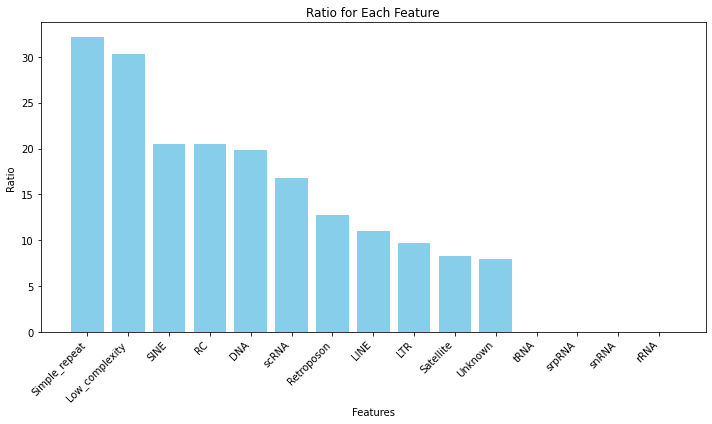

In [43]:
ratio = list(np.array(perc_positives)/np.array(mean_prob_to_sample_f))

sorted_data = sorted(zip(ratio, features), reverse=True)
ratio, features = zip(*sorted_data)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, perc_positives, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Ratio ')
plt.title('Ratio for Each Feature')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

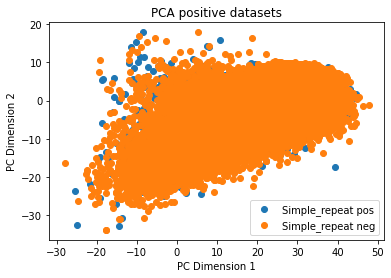

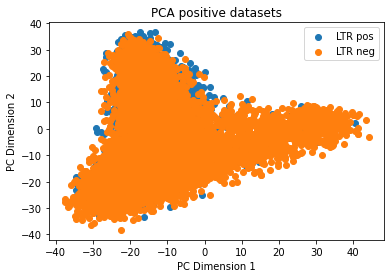

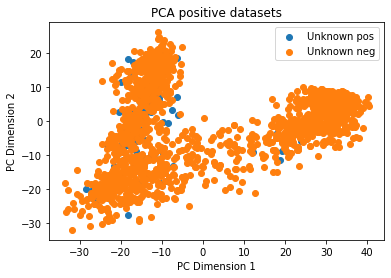

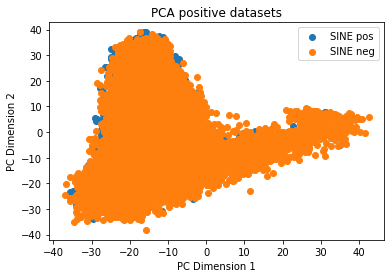

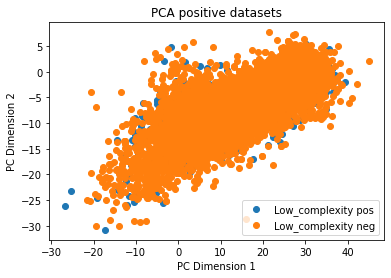

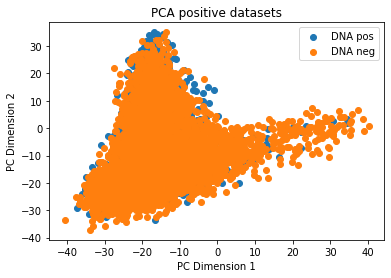

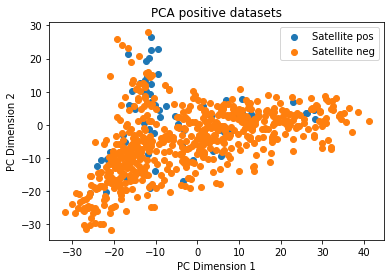

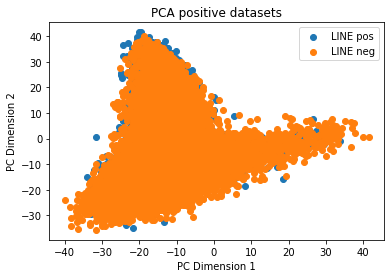

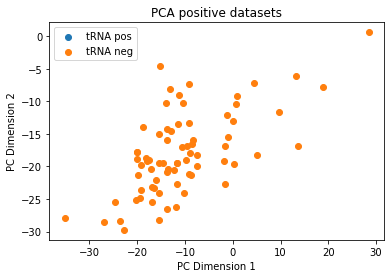

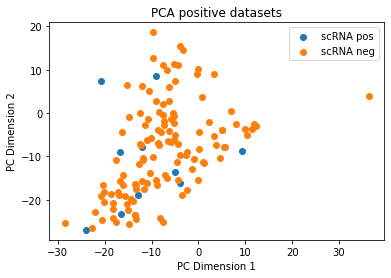

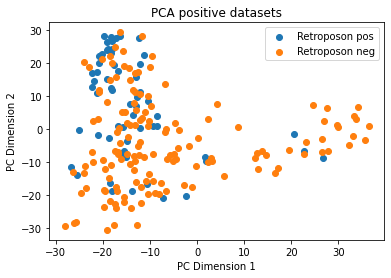

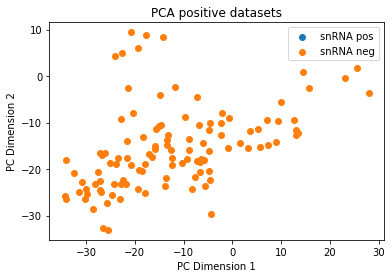

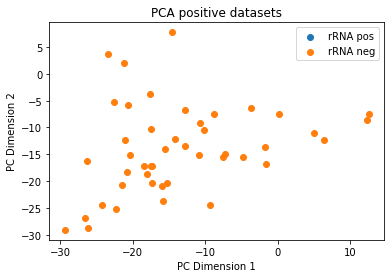

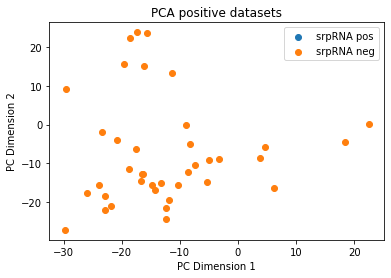

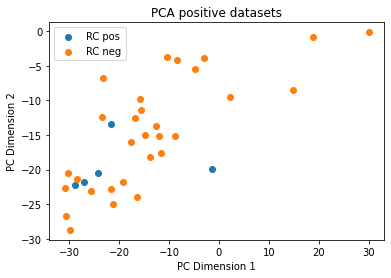

In [45]:
repeats_df_pos = repeats_df[repeats_df['interacting'] == True]
repeats_df_neg = repeats_df[repeats_df['interacting'] == False]
for f in list(repeats_df.feature.unique()):
    plt.scatter(repeats_df_pos[repeats_df_pos.feature == f][f'PC1'], repeats_df_pos[repeats_df_pos.feature == f][f'PC2'], label=f+' pos')
    plt.scatter(repeats_df_neg[repeats_df_neg.feature == f][f'PC1'], repeats_df_neg[repeats_df_neg.feature == f][f'PC2'], label=f+' neg')
    plt.title('PCA positive datasets')
    plt.xlabel(f"PC Dimension 1")
    plt.ylabel(f"PC Dimension 2")
    plt.legend()
    plt.show()

# Classifier

In [19]:
random_seed = 23

In [20]:
# X = posneg_features
# y = pd.Series([0 if i == 'negative' else 1 for i in final_df_posneg['how']])

# # subsample training data
# train_x, test_x, train_y, test_y = train_test_split(
#     X, y, train_size=0.8, stratify=y, random_state = random_seed
# )

In [21]:
train_condition = (df_posneg.dataset == 'paris')
train_x = posneg_features[train_condition]
train_y = pd.Series([0 if i == 'negative' else 1 for i in df_posneg[train_condition]['how']])
                    
    
test_condition = (df_posneg.dataset == 'ricseq')|(df_posneg.dataset == 'splash')
test_x = posneg_features[test_condition]
test_y = pd.Series([0 if i == 'negative' else 1 for i in df_posneg[test_condition]['how']])

In [22]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((68185, 2560), (68185,), (4286, 2560), (4286,))

In [23]:
np.unique(test_y, return_counts = True)

(array([0, 1]), array([2142, 2144]))

In [24]:
pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=random_seed)) #Normalizer(), 

In [25]:
pipeline.fit(train_x, train_y)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=23))])

In [26]:
pipeline.score(train_x, train_y)

0.9576593092322359

In [27]:
pipeline.score(test_x, test_y)

0.9437704153056463

# Explained Variance Ratio

##### Pos/neg

2 variables explain the 5.77% of the variance


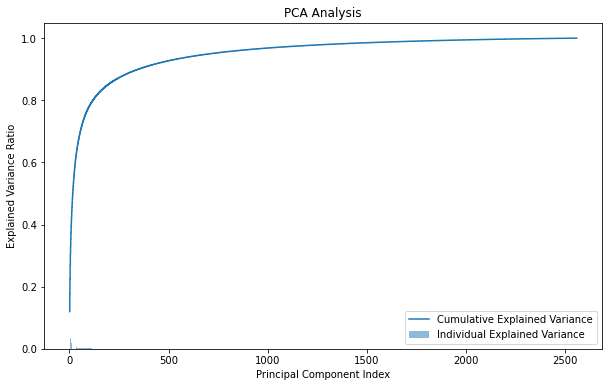

In [30]:
n_feat = numerical_features_scaled.shape[1]

# Step 1: Initialize PCA
pca = PCA(n_components=n_feat)

# Step 2: Fit and transform your data
pca_result = pca.fit_transform(numerical_features_scaled)

# Step 3: Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f'2 variables explain the {np.round(explained_variance_ratio[1] * 100, 2)}% of the variance')

# Step 5: Plotting
plt.figure(figsize=(10, 6))

# Plotting individual explained variance as a histogram
plt.bar(range(1, n_feat+1), explained_variance_ratio, label='Individual Explained Variance', alpha=0.5)

# Plotting cumulative explained variance as a step function
plt.step(range(1, n_feat+1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Analysis')
plt.legend()

# Show the plot
plt.show()

##### Repeats

2 variables explain the 9.09% of the variance


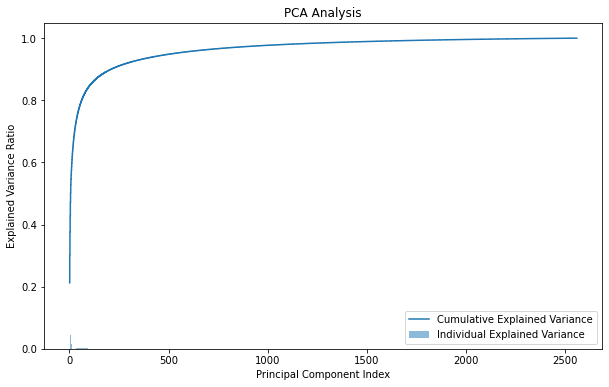

In [31]:
n_feat = numerical_features_scaled.shape[1]

# Step 1: Initialize PCA
pca = PCA(n_components=n_feat)

# Step 2: Fit and transform your data
pca_result = pca.fit_transform(df_features)

# Step 3: Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f'2 variables explain the {np.round(explained_variance_ratio[1] * 100, 2)}% of the variance')

# Step 5: Plotting
plt.figure(figsize=(10, 6))

# Plotting individual explained variance as a histogram
plt.bar(range(1, n_feat+1), explained_variance_ratio, label='Individual Explained Variance', alpha=0.5)

# Plotting cumulative explained variance as a step function
plt.step(range(1, n_feat+1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Analysis')
plt.legend()

# Show the plot
plt.show()